# Z2 lattice gauge theory

In [1]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import c2qa
import qiskit
import numpy as np
import scipy
import itertools
import c2qa.util as util
import evo
import c2qa.stateReadout as stateReadout
import matplotlib.pyplot as plt
import matplotlib
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from collections import Counter

# 1. Testing the controlled phase beamsplitter oscillation

### Create a circuit with as many modes as qubits

In [54]:
numberofmodes=2
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=1)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [55]:
diffstallmodes=[1,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

The printed output of util.stateread shows the boson oscillating between the two modes at every time step.

In [56]:
dt=1
m=1
g=1
N=5

circuit.h(qbr[0]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
stateop, _ = c2qa.util.simulate(circuit)
print("Initial state ")
util.stateread(stateop, qbr.size, numberofmodes, cutoff)
print("At each time step")
for i in range(N):
    print("dt+1")
    evo.eiht(circuit, qmr[0], qmr[1], qbr[0], m, g, dt)
    stateop, _ = c2qa.util.simulate(circuit)
    util.stateread(stateop, qbr.size, numberofmodes, cutoff)

Initial state 
qumodes:  01  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  0.7071067811865475
occupation modes  [0.0, 1.0]
occupation qubits  [0.4999999999999999]
At each time step
dt+1
qumodes:  10  qubits:  0     with amplitude:  -0.6205445805637456
qumodes:  10  qubits:  1     with amplitude:  0.6205445805637455
occupation modes  [0.7701511529340699, 0.0]
occupation qubits  [0.38507557646703483]
dt+1
qumodes:  01  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  -0.7071067811865475
occupation modes  [0.0, 1.0]
occupation qubits  [0.4999999999999999]
dt+1
qumodes:  10  qubits:  0     with amplitude:  0.6205445805637456
qumodes:  10  qubits:  1     with amplitude:  -0.6205445805637455
occupation modes  [0.7701511529340699, 0.0]
occupation qubits  [0.38507557646703483]
dt+1
qumodes:  01  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  0.70

Measuring collapses the boson to one mode and the qubit to one state.

In [57]:
circuit.measure(qbr[0],cbr[0])
stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qumodes:  10  qubits:  1     with amplitude:  0.8775825618903726
occupation modes  [0.7701511529340698, 0.0]
occupation qubits  [0.7701511529340698]
Counts(ideal): {'0': 503, '1': 521}


# 2. Circuit demonstrating mode & qubit occupation for Z2LGT (Aidelsburger Nature)
If the beamsplitter term is more important than the flipping of the gauge field, an oscillation and spreading of the boson will occur between the modes.
If the flipping of the gauge field is larger than the boson hopping beamsplitter term, then the qubits will flip backwards and forwards so fast that on average there will be nearly no action of the beamsplitter

#### Create a circuit with as many modes as qubits

In [15]:
numberofqubits=2
numberofmodes=3
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

#### Initialise, e.g. share one boson between the cavities by initialising one cavity to Fock state 1 and the others to the vacuum.

In [16]:
diffstallmodes=[0,1,1]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

qumodes:  110  qubits:  00     with amplitude:  1.0
occupation modes  [1.0, 1.0, 0.0]
occupation qubits  [0.0, 0.0]


### 2.1 Gauge field flipping dominates

In [17]:
dt=0.1
N=10
m=1
# g=0.1 beamsplitter dominates or g=2 gauge field flipping dominates

occupations = evo.trotterise_Z2LGT(circuit, numberofmodes, numberofqubits, qmr, qbr, cutoff, 10, m, 2, dt)

dt+1 0.0
qumodes:  011  qubits:  00     with amplitude:  0.011991968145559351
qumodes:  020  qubits:  00     with amplitude:  -0.10790890800033506
qumodes:  101  qubits:  00     with amplitude:  -0.07725424859373685
qumodes:  110  qubits:  00     with amplitude:  0.46031151173407114
qumodes:  200  qubits:  00     with amplitude:  0.10790890800033505
qumodes:  011  qubits:  01     with amplitude:  -0.01199196814555935
qumodes:  020  qubits:  01     with amplitude:  -0.10790890800033505
qumodes:  101  qubits:  01     with amplitude:  0.07725424859373684
qumodes:  110  qubits:  01     with amplitude:  0.4603115117340711
qumodes:  200  qubits:  01     with amplitude:  0.10790890800033504
qumodes:  011  qubits:  10     with amplitude:  -0.01199196814555935
qumodes:  020  qubits:  10     with amplitude:  0.10790890800033505
qumodes:  101  qubits:  10     with amplitude:  -0.07725424859373684
qumodes:  110  qubits:  10     with amplitude:  0.4603115117340711
qumodes:  200  qubits:  10     wit

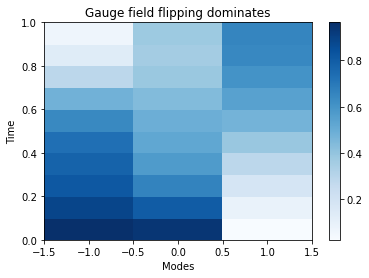

In [18]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occupations[0],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("Gauge field flipping dominates")
plt.xlabel("Modes")
plt.ylabel("Time")
plt.colorbar()

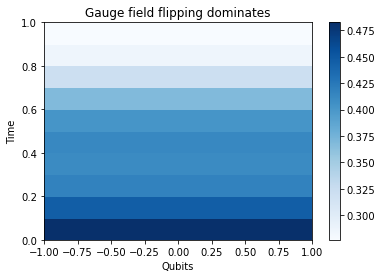

In [19]:
plt.pcolormesh(np.arange(numberofqubits+1)-numberofqubits//2,np.arange(N+1)*dt,occupations[1],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("Gauge field flipping dominates")
plt.xlabel("Qubits")
plt.ylabel("Time")
plt.colorbar()

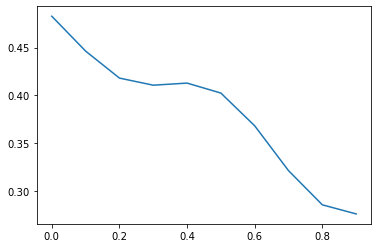

In [30]:
plt.plot(np.arange(N)*dt,occupations[1][:,0])

### 2.2 Boson hopping dominates

In [31]:
numberofqubits=2
numberofmodes=3
numberofqubitspermode=2
cutoff=2**numberofqubitspermode
qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
diffstallmodes=[0,1,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

dt=0.1
N=10
m=1
# g=0.1 beamsplitter dominates or g=2 gauge field flipping dominates

occupations = evo.trotterise_Z2LGT(circuit, numberofmodes, numberofqubits, qmr, qbr, cutoff, 10, m, 0.1, dt)

dt+1 0.0
qumodes:  001  qubits:  00     with amplitude:  -0.07821723252011543
qumodes:  010  qubits:  00     with amplitude:  0.4877397410705691
qumodes:  100  qubits:  00     with amplitude:  0.07725424859373684
qumodes:  001  qubits:  01     with amplitude:  0.07821723252011542
qumodes:  010  qubits:  01     with amplitude:  0.487739741070569
qumodes:  100  qubits:  01     with amplitude:  0.07725424859373682
qumodes:  001  qubits:  10     with amplitude:  -0.07821723252011542
qumodes:  010  qubits:  10     with amplitude:  0.48773974107056906
qumodes:  100  qubits:  10     with amplitude:  -0.07725424859373682
qumodes:  001  qubits:  11     with amplitude:  0.0782172325201154
qumodes:  010  qubits:  11     with amplitude:  0.487739741070569
qumodes:  100  qubits:  11     with amplitude:  -0.07725424859373682
occupation modes  [0.023872875703131555, 0.951560220078343, 0.024471741852423203]
occupation qubits  [0.4999524188169488, 0.4999524188169487]
dt+1 0.1


/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


qumodes:  001  qubits:  00     with amplitude:  -0.15355355406697208
qumodes:  010  qubits:  00     with amplitude:  0.45156328326706213
qumodes:  100  qubits:  00     with amplitude:  0.1497489430862501
qumodes:  001  qubits:  01     with amplitude:  0.15355355406697205
qumodes:  010  qubits:  01     with amplitude:  0.45156328326706197
qumodes:  100  qubits:  01     with amplitude:  0.14974894308625009
qumodes:  001  qubits:  10     with amplitude:  -0.15355355406697202
qumodes:  010  qubits:  10     with amplitude:  0.4515632832670621
qumodes:  100  qubits:  10     with amplitude:  -0.14974894308625009
qumodes:  001  qubits:  11     with amplitude:  0.153553554066972
qumodes:  010  qubits:  11     with amplitude:  0.45156328326706197
qumodes:  100  qubits:  11     with amplitude:  -0.14974894308625009
occupation modes  [0.08969898382179588, 0.8156375951797157, 0.09431477586639402]
occupation qubits  [0.4998256774339527, 0.49982567743395256]
dt+1 0.2
qumodes:  001  qubits:  00     wi

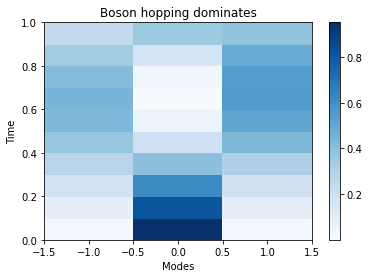

In [32]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occupations[0],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("Boson hopping dominates")
plt.xlabel("Modes")
plt.ylabel("Time")
plt.colorbar()

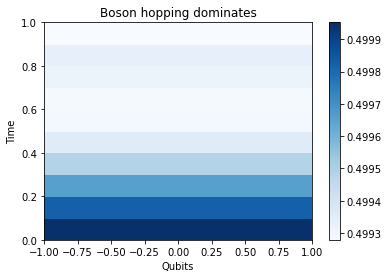

In [33]:
plt.pcolormesh(np.arange(numberofqubits+1)-numberofqubits//2,np.arange(N+1)*dt,occupations[1],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("Boson hopping dominates")
plt.xlabel("Qubits")
plt.ylabel("Time")
plt.colorbar()

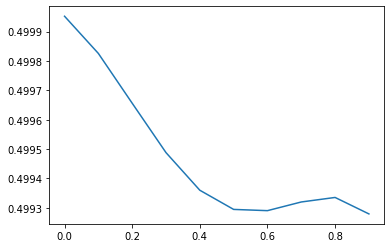

In [34]:
plt.plot(np.arange(N)*dt,occupations[1][:,0])

In [ ]:
circuit.draw(output='mpl', filename='lgt_circuit.png')

In [13]:
circuit.measure(qbr[0],cbr[0])
stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qumodes:  00001  qubits:  0000     with amplitude:  0.338220999270756
qumodes:  00010  qubits:  0000     with amplitude:  -0.14002737094382492
qumodes:  00100  qubits:  0000     with amplitude:  -0.1528367010913309
qumodes:  01000  qubits:  0000     with amplitude:  0.12324444452377559
qumodes:  10000  qubits:  0000     with amplitude:  0.39347163915792205
qumodes:  00001  qubits:  0010     with amplitude:  -0.25425951835743027
qumodes:  00010  qubits:  0010     with amplitude:  -0.16920517465353094
qumodes:  00100  qubits:  0010     with amplitude:  -0.08475298329637684
qumodes:  01000  qubits:  0010     with amplitude:  -0.15114739321955906
qumodes:  10000  qubits:  0010     with amplitude:  -0.1284426065014453
qumodes:  00001  qubits:  0100     with amplitude:  -0.16558421818338023
qumodes:  00010  qubits:  0100     with amplitude:  0.2206230435829014
qumodes:  00100  qubits:  0100     with amplitude:  -0.11251652595376664
qumodes:  01000  qubits:  0100     with amplitude:  0.198146

# 3. Circuit demonstrating Gauss's law
Gauss' law: electric flux through an arbitrary surface is proportional to the charge contained within the surface.
Analogy: flipping of the gauge field either side of a site is proportional to the boson number contained on that site.
< exp^(i Pi n)  X X>


### 3.1 Middle site 2 at t=0
Initially, the central site is charged: exp^(i Pi n)  = -1 and the gauge qubits are in |+>: X X = 1
Therefore, < exp^(i Pi n) X X> =  -1 which, renormalised to sit between 0 and 1 (as are the results of reading out a qubit), corresponds to 0. (Somehow my signs are flipped and I measure the result of the Hadamard test to be 1.)
Having an initially empty site corresponds to 1. (I measure to be 0.)

Result of the Hadamard test is 1 (see explanation above)

qumodes:  00100  qubits:  00000     with amplitude:  1.0
occupation modes  [0.0, 0.0, 1.0, 0.0, 0.0]
occupation qubits  [0.0, 0.0, 0.0, 0.0, 0.0]
Counts(ideal): {'1': 1024}


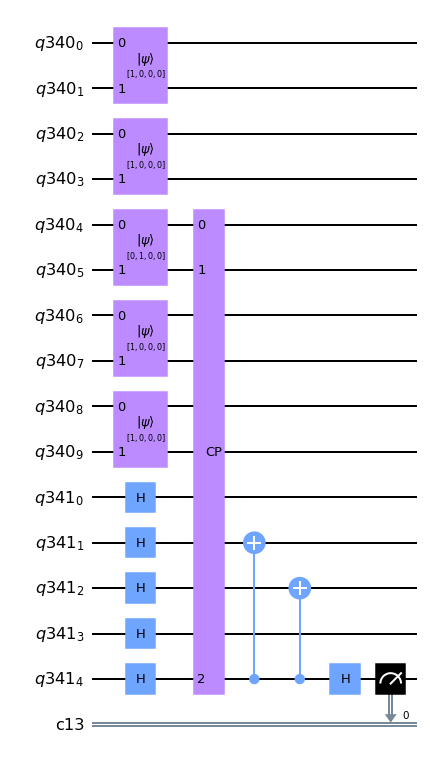

In [38]:
numberofqubits=4+1 # the extra one is for the Hadamard test
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1) # To read out the results of the Hadamard test
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

# The first Hadamard gate on the Hadamard test qubit is usually done in trotterise_Z2LGT but not here
for i in range(0,numberofqubits):
    circuit.h(qbr[i])
site=2
circuit.cv_cp(np.pi/2, qmr[site], qbr[-1])
circuit.cnot(qbr[-1],qbr[site-1])
circuit.cnot(qbr[-1],qbr[site])
circuit.h(qbr[-1])
circuit.measure(-1,0)

circuit.draw(output='mpl', filename='initial-state_hadmard-test.png')

stateop, result = c2qa.util.simulate(circuit)
# util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

### 3.2. Other than middle qubits t=0
The result of the Hadamard test is 0 because for a site with no bosons < exp^(i Pi n) X X> = 1

In [45]:
numberofqubits=4+1 # the extra one is for the Hadamard test
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1) # To read out the results of the Hadamard test
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

# The first Hadamard gate on the Hadamard test qubit is usually done in trotterise_Z2LGT but not here
for i in range(0,numberofqubits):
    circuit.h(qbr[i])
site=3
circuit.cv_cp(np.pi/2, qmr[site], qbr[-1])
circuit.cnot(qbr[-1],qbr[site-1])
circuit.cnot(qbr[-1],qbr[site])
circuit.h(qbr[-1])
circuit.measure(-1,0)

stateop, result = c2qa.util.simulate(circuit)
# util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qumodes:  00100  qubits:  00000     with amplitude:  1.0
occupation modes  [0.0, 0.0, 1.0, 0.0, 0.0]
occupation qubits  [0.0, 0.0, 0.0, 0.0, 0.0]
Counts(ideal): {'0': 1024}


### 3.3. Conservation at later times
The result of the Hadamard test remains unchanged for, e.g., the central site

qumodes:  00100  qubits:  00000     with amplitude:  1.0
occupation modes  [0.0, 0.0, 1.0, 0.0, 0.0]
occupation qubits  [0.0, 0.0, 0.0, 0.0, 0.0]
dt+1 0.0
qumodes:  00010  qubits:  00000     with amplitude:  -0.02731213586435551
qumodes:  00100  qubits:  00000     with amplitude:  0.17241617266114015
qumodes:  01000  qubits:  00000     with amplitude:  0.02731213586435551
qumodes:  10000  qubits:  00000     with amplitude:  0.004326033652823775
qumodes:  00010  qubits:  00001     with amplitude:  -0.0273121358643555
qumodes:  00100  qubits:  00001     with amplitude:  0.1724161726611401
qumodes:  01000  qubits:  00001     with amplitude:  0.027312135864355498
qumodes:  10000  qubits:  00001     with amplitude:  0.004326033652823773
qumodes:  00010  qubits:  00010     with amplitude:  0.0273121358643555
qumodes:  00100  qubits:  00010     with amplitude:  0.1724161726611401
qumodes:  01000  qubits:  00010     with amplitude:  0.027312135864355498
qumodes:  10000  qubits:  00010     with

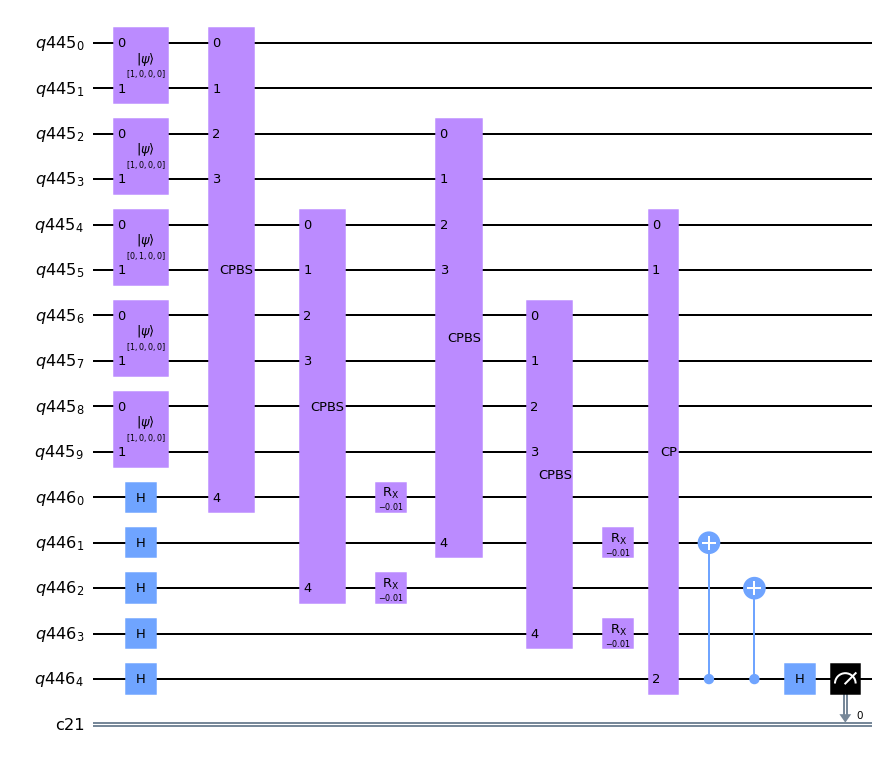

In [46]:
numberofqubits=4+1 # the extra one is for the Hadamard test
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1) # To read out the results of the Hadamard test
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

dt=0.1
m=1
N=1

evo.trotterise_Z2LGT(circuit, numberofmodes, numberofqubits, qmr, qbr, cutoff, N, m, 0.1, dt)
# The first Hadamard gate on the Hadamard test qubit is done in trotterise_Z2LGT
site=2
circuit.cv_cp(np.pi/2, qmr[site], qbr[-1])
circuit.cnot(qbr[-1],qbr[site-1])
circuit.cnot(qbr[-1],qbr[site])
circuit.h(qbr[-1])
circuit.measure(-1,0)

circuit.draw(output='mpl', filename='initial-state_hadmard-test.png')

stateop, result = c2qa.util.simulate(circuit)
# util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qumodes:  00100  qubits:  00000     with amplitude:  1.0
occupation modes  [0.0, 0.0, 1.0, 0.0, 0.0]
occupation qubits  [0.0, 0.0, 0.0, 0.0, 0.0]
dt+1 0.0
qumodes:  00010  qubits:  00000     with amplitude:  -0.02731213586435551
qumodes:  00100  qubits:  00000     with amplitude:  0.17241617266114015
qumodes:  01000  qubits:  00000     with amplitude:  0.02731213586435551
qumodes:  10000  qubits:  00000     with amplitude:  0.004326033652823775
qumodes:  00010  qubits:  00001     with amplitude:  -0.0273121358643555
qumodes:  00100  qubits:  00001     with amplitude:  0.1724161726611401
qumodes:  01000  qubits:  00001     with amplitude:  0.027312135864355498
qumodes:  10000  qubits:  00001     with amplitude:  0.004326033652823773
qumodes:  00010  qubits:  00010     with amplitude:  0.0273121358643555
qumodes:  00100  qubits:  00010     with amplitude:  0.1724161726611401
qumodes:  01000  qubits:  00010     with amplitude:  0.027312135864355498
qumodes:  10000  qubits:  00010     with

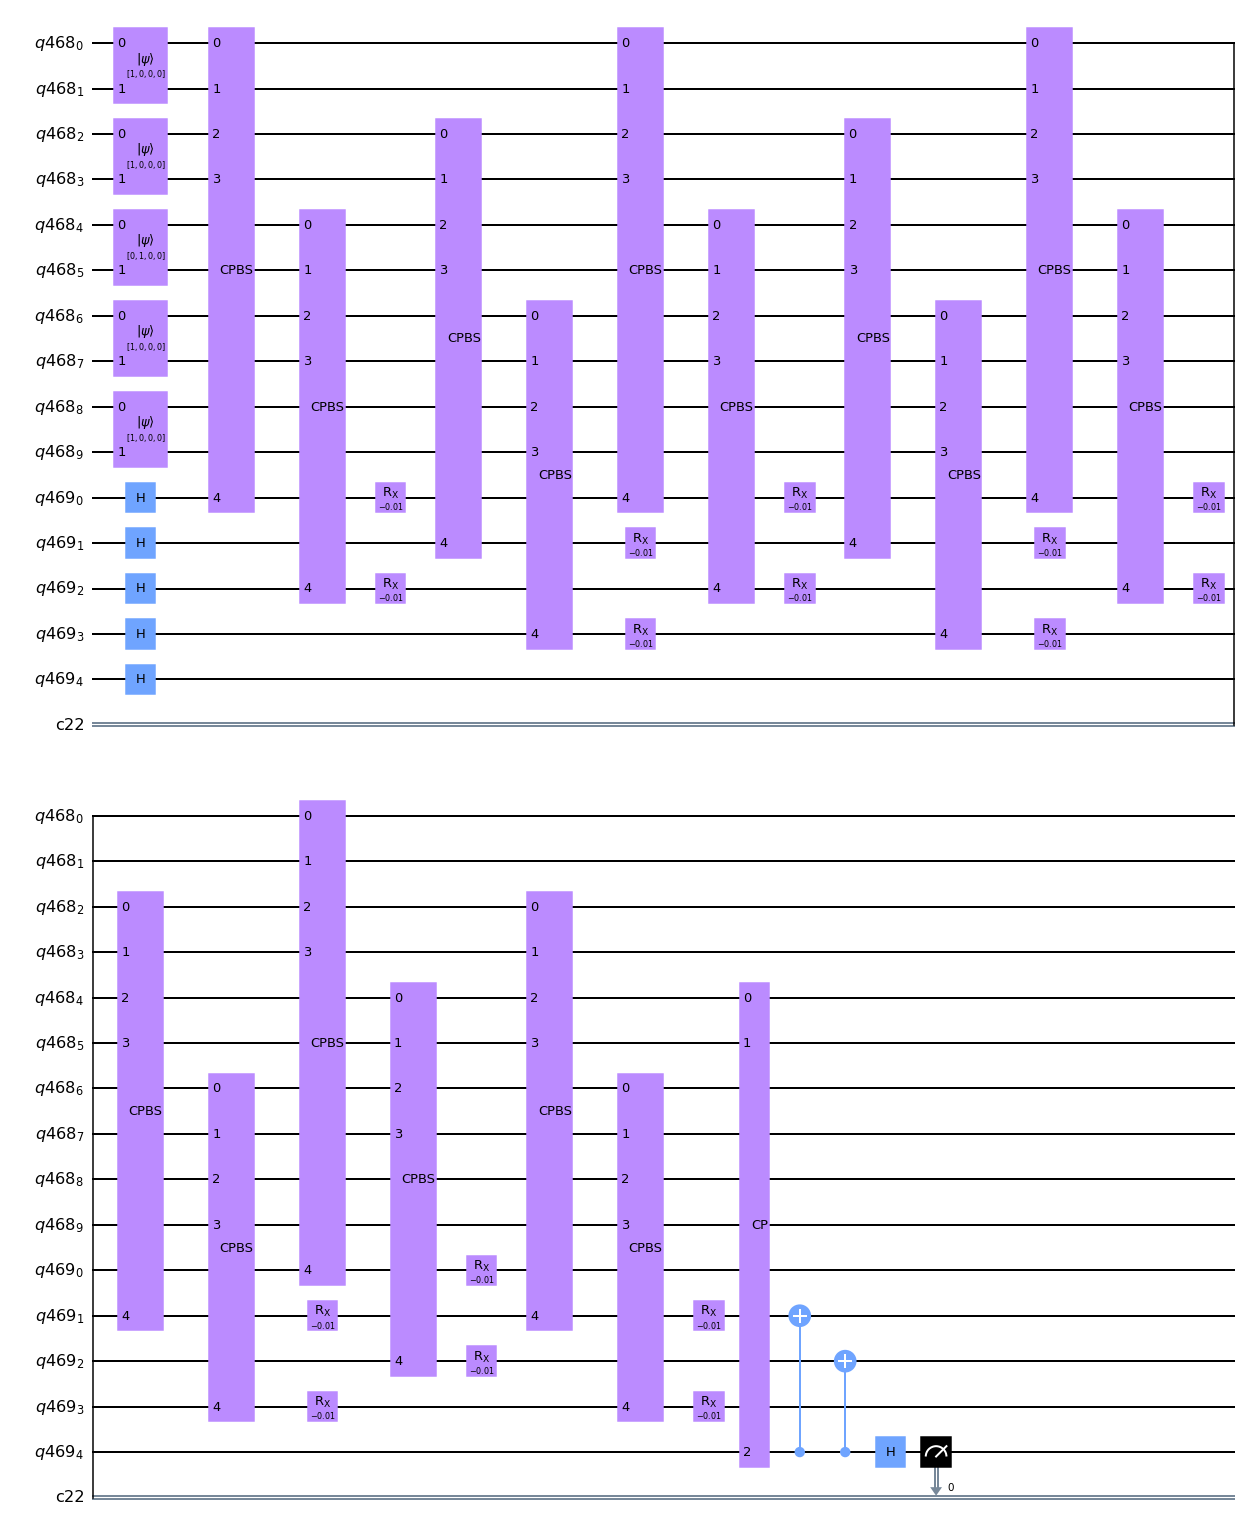

In [47]:
numberofqubits=4+1 # the extra one is for the Hadamard test
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1) # To read out the results of the Hadamard test
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

dt=0.1
m=1
N=4 # number of timesteps

evo.trotterise_Z2LGT(circuit, numberofmodes, numberofqubits, qmr, qbr, cutoff, N, m, 0.1, dt)
# The first Hadamard gate on the Hadamard test qubit is done in trotterise_Z2LGT
site=2
circuit.cv_cp(np.pi/2, qmr[site], qbr[-1])
circuit.cnot(qbr[-1],qbr[site-1])
circuit.cnot(qbr[-1],qbr[site])
circuit.h(qbr[-1])
circuit.measure(-1,0)

circuit.draw(output='mpl', filename='initial-state_hadmard-test.png')

stateop, result = c2qa.util.simulate(circuit)
# util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())